<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/24_2_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D1%83%D0%B7%D1%8B%D0%BA%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B6%D0%B0%D0%BD%D1%80%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Обработка аудиосигналов](https://colab.research.google.com/drive/13r2TM72wK5mFSMsb1rBV4gspNCqkzJDY)
2. Распознавание музыкального жанра
3. [Генерация музыкальных произведений с помощью НС](https://colab.research.google.com/drive/1mxiZYMIVk_RhgNB_kXsySMkA-O2HkpHF)
4. [Домашняя работа](https://colab.research.google.com/drive/1uZ-sCic9BV5quOohckycIqhYkl8MvvvV)

## Распознавание музыкального жанра

В первой части урока мы познакомились с выявлением признаков в аудиофайлах. Воспользуемся этим знанием и обучим нейронную сеть распознавать музыкальные жанры, ориентируясь на выявленные признаки. В данной задаче мы выдвигаем гипотезу, что для разных музыкальных жанров будут проявляться свои индивидуальные признаки, а на их отличиях мы сможем построить модель, угадывающую жанр мелодии или, например, создать рекомендательную модель, подбирающую под вас музыку. В подверждение гипотезы можно привести пример, что если собрать мелодии, которые вам нравятся, то у них будут схожие сонограммы.  

### Импорт библиотек и загрузка датасета

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Преобразование категориальных данных в one hot encoding
from keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from keras.models import Sequential, Model, load_model

# Основные слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

В качестве датасета возьмем публичный набор данных [GTZAN Dataset - Music Genre Classification](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/).

Датасет уникален тем, что помимо коллекции аудиофалов (10 жанров по 100 аудиофайлов в каждом продолжительностью 30 секунд), также содержит и визуальные представления музыкальных произведений (мел-спектрограммы) и уже посчитанные признаки в электронных таблицах.

Однако мы не будем упрощать себе задачу и извлечем признаки самостоятельно.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/gtzan-dataset-music-genre-classification.zip

--2024-04-11 08:03:10--  https://storage.yandexcloud.net/academy.ai/gtzan-dataset-music-genre-classification.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1301492495 (1.2G) [application/x-zip-compressed]
Saving to: ‘gtzan-dataset-music-genre-classification.zip’

gtzan-dataset-music 100%[===================>]   1.21G  15.9MB/s    in 82s     

2024-04-11 08:04:33 (15.2 MB/s) - ‘gtzan-dataset-music-genre-classification.zip’ saved [1301492495/1301492495]



In [ ]:
# Распаковка архива
!unzip -qo gtzan-dataset-music-genre-classification.zip

In [ ]:
# Установка констант

FILE_DIR = './Data/genres_original'       # Папка с файлами датасета

CLASS_LIST = os.listdir(FILE_DIR)         # Список классов
CLASS_LIST.sort()

CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

### Вспомогательные функции

Далее нам необходимо написать функцию извлечения признаков, о которых мы говорили в первой части урока.

In [ ]:
# Функция извлечения признаков
def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 hop_length=HOP_LENGTH  # шаг скользящего окна
                 ):

    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)

    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)

    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length)

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)

    # Создадим общий словарь с параметрами
    return {
        'spec_cent': spec_cent,
        'rolloff': rolloff,
        'zcr' : zcr,
        'mfcc': mfcc,
        'chroma_stft': chroma_stft
    }

Определим функцию объединения признаков в набор векторов

In [ ]:
# Функция объединения признаков в набор векторов
def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T # транспонируем матрицу

Определим функцию загрузки файла, его анализа и формирования признаков и меток классов для этого файла.

In [ ]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []

    # Извлечение имени произведения
    class_name = CLASS_LIST[class_index]

    # Путь к файлу
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.wav'

    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)


    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

Определим функцию оценки точности работы модели и отрисовки матрицы ошибки

In [ ]:
# Функция оценки точности модели на заданной выборке

def eval_model(model,  # обученная модель нейронной сети
               x,      # входные данные
               y_true  # выходные данные (верные ответы)
               ):
    loss, acc = model.evaluate(x, y_true)
    print(f'Ошибка: {loss}, точность: {acc}')

    # Построение матрицы ошибок
    y_pred = model.predict(x)
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок нормализованная')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

### Формирование обучающей выборки

In [ ]:
x_train_data = None
y_train_data = None

x_test = None
y_test = None

for class_index in range(len(CLASS_LIST)):
    # Для всех файлов текущего класса из заданного диапазона номеров:
    for file_index in range(0, FILE_INDEX_TRAIN_SPLIT):
      try:
        # Обработка одного файла и добавление данных к выборке
        _, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
        x_train_data = file_x_data if x_train_data is None else np.vstack([x_train_data, file_x_data])
        y_train_data = file_y_data if y_train_data is None else np.vstack([y_train_data, file_y_data])
      except:
        continue

    # Формирование тестовой выборки из файлов, не вошедших в основной набор
    for file_index in range(FILE_INDEX_TRAIN_SPLIT, CLASS_FILES):
      try:
        # Обработка одного файла и добавление данных к выборке
        _, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)
        x_test = file_x_data if x_test is None else np.vstack([x_test, file_x_data])
        y_test = file_y_data if y_test is None else np.vstack([y_test, file_y_data])
      except:
        continue



### Нормирование входных признаков

Так как мы используем различные по сути и значению признаки (фактически сраниваем "мух" и "котлеты"), то все входные признаки необходимо нормировать, чтобы они имели значения одного порядка. Для этого воспользуемся стандартным нормальным распределением.

In [ ]:
# Нормирование признаков основной выборки в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Нормирование признаков тестовой выборки в соответствии со стандартным нормальным распределением
x_test = x_scaler.transform(x_test)

### Разделение выборки на обучающую и проверочную

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
# Проверка формы обучающей, проверочной и тестовой выборок

print(f'Обучающая выборка (входные признаки): {x_train.shape}')
print(f'Обучающая выборка (метки классов): {y_train.shape}')
print()
print(f'Проверочная выборка (входные признаки): {x_val.shape}')
print(f'Проверочная выборка (метки классов): {y_val.shape}')
print()
print(f'Тестовая выборка (входные признаки): {x_test.shape}')
print(f'Тестовая выборка (метки классов): {y_test.shape}')

Обучающая выборка (входные признаки): (1045355, 35)
Обучающая выборка (метки классов): (1045355, 10)

Проверочная выборка (входные признаки): (116151, 35)
Проверочная выборка (метки классов): (116151, 10)

Тестовая выборка (входные признаки): (129200, 35)
Тестовая выборка (метки классов): (129200, 10)


### Архитектура нейронной сети

Для данной задачи классификации будем использовать полносвязную модель с нормализацией по пакетам `BatchNormalization` и регуляризацией `Dropout` между плотными слоями.

In [ ]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=x_train.shape[1:]))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(CLASS_COUNT, activation='softmax'))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy',  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               9216      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

### Обучение модели

In [ ]:
# Обучение модели
history = model.fit(x_train, y_train, epochs=100, batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/100
2042/2042 [==============================] - 18s 6ms/step - loss: 1.8976 - accuracy: 0.3347 - val_loss: 1.5028 - val_accuracy: 0.4683
Epoch 2/100
2042/2042 [==============================] - 12s 6ms/step - loss: 1.5908 - accuracy: 0.4296 - val_loss: 1.3902 - val_accuracy: 0.5073
Epoch 3/100
2042/2042 [==============================] - 12s 6ms/step - loss: 1.4901 - accuracy: 0.4671 - val_loss: 1.3055 - val_accuracy: 0.5366
Epoch 4/100
2042/2042 [==============================] - 12s 6ms/step - loss: 1.4225 - accuracy: 0.4914 - val_loss: 1.2445 - val_accuracy: 0.5584
Epoch 5/100
2042/2042 [==============================] - 12s 6ms/step - loss: 1.3735 - accuracy: 0.5101 - val_loss: 1.1975 - val_accuracy: 0.5746
Epoch 6/100
2042/2042 [==============================] - 13s 6ms/step - loss: 1.3387 - accuracy: 0.5235 - val_loss: 1.1622 - val_accuracy: 0.5885
Epoch 7/100
2042/2042 [==============================] - 13s 6ms/step - loss: 1.3083 - accuracy: 0.5350 - val_loss: 1.1326 -

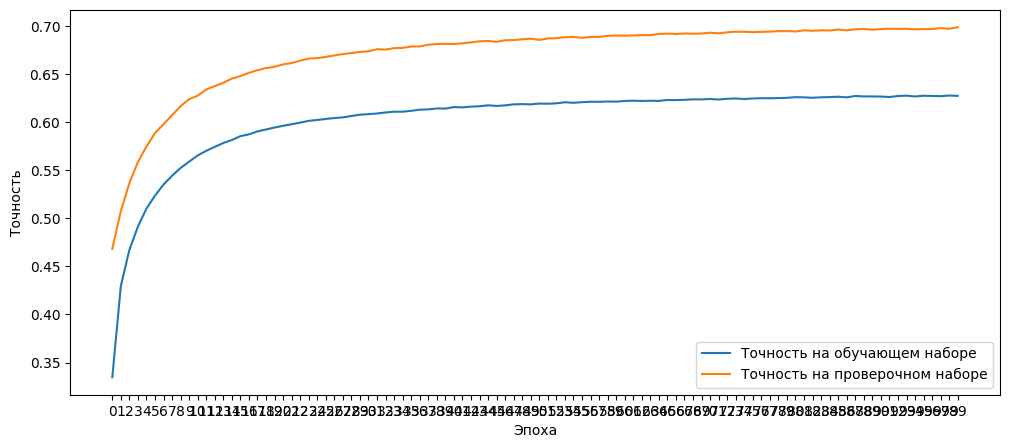

In [ ]:
# Вывод графика точности распознавания на обучающей и проверочной выборках
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xticks(history.epoch)
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

### Оценка точности модели

Воспользуемся функцией `eval_model()` для оценки результатов обученной полносвязной модели.

Оценим на проверочной выборке:

3630/3630 [==============================] - 9s 2ms/step - loss: 0.8701 - accuracy: 0.6986
Ошибка: 0.8701263070106506, точность: 0.6985734105110168
3630/3630 [==============================] - 7s 2ms/step


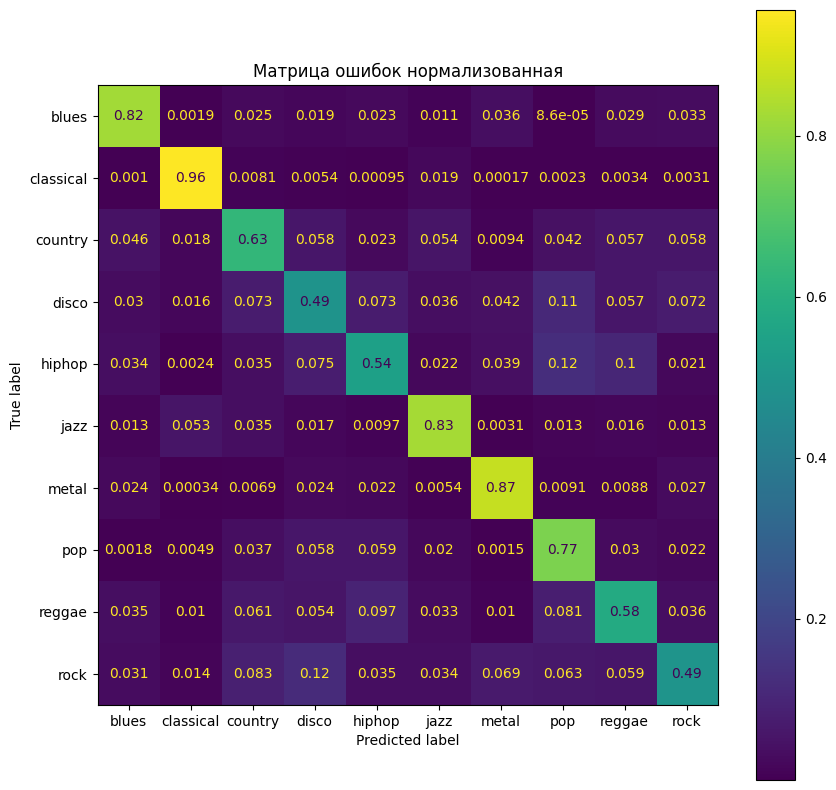

In [ ]:
# Оценка точности сети на проверочной выборке
eval_model(model, x_val, y_val)

И на тестовой выборке:

4038/4038 [==============================] - 10s 3ms/step - loss: 1.6668 - accuracy: 0.4440
Ошибка: 1.6668386459350586, точность: 0.4440170228481293
4038/4038 [==============================] - 7s 2ms/step


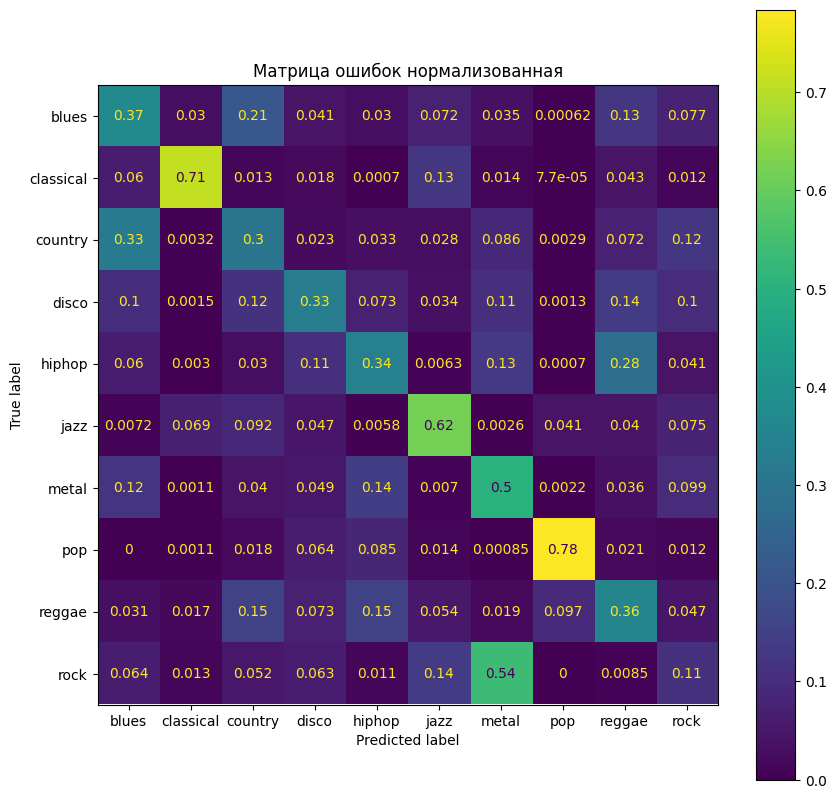

In [ ]:
# Оценка точности сети на тестовой выборке
eval_model(model, x_test, y_test)

Матрица ошибок позволяет нам анализировать результаты распознавания. По вертикальной оси показаны правильные метки классов (жанров музыки), по горизонтали – метки, предсказанные моделью.

Общая логика нормализованной матрицы ошибок проста: чем ближе к **1** диагональные значения - тем лучше. Соответственно, в других ячейках матрицы (ошибочные распознавания) значения должны быть как можно меньше, в идеале **0**.

Точность на проверочной выборке составила почти 70%, в то время как на тестовой всего 44%.

### Определение жанра произвольного файла

Возьмем для примера произведение Бетховена "К Элизе" из первой части урока. Загрузим с помощью библиотеки `librosa`, извлечем признаки, нормализуем и отправим их в нашу модель для предсказания.

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Beethoven_Fur_Elise.mp3

--2024-04-11 08:52:48--  https://storage.yandexcloud.net/academy.ai/Beethoven_Fur_Elise.mp3
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3918257 (3.7M) [audio/mpeg]
Saving to: ‘Beethoven_Fur_Elise.mp3.1’

Beethoven_Fur_Elise 100%[===================>]   3.74M  2.53MB/s    in 1.5s    

2024-04-11 08:52:51 (2.53 MB/s) - ‘Beethoven_Fur_Elise.mp3.1’ saved [3918257/3918257]



In [ ]:
y, sr = librosa.load('./Beethoven_Fur_Elise.mp3', mono=True, duration=DURATION_SEC)

# Извлечение параметров из аудиосигнала
features = get_features(y, sr)
feature_set = stack_features(features)

In [ ]:
file_x_data = x_scaler.transform(feature_set)

41/41 [==============================] - 0s 2ms/step


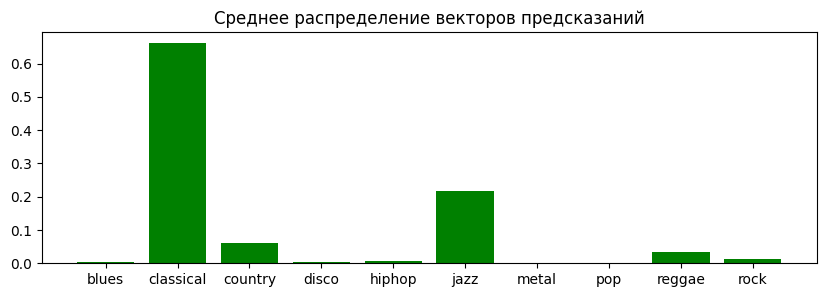

In [ ]:
# Вычисление предсказания по выборке
predict = model.predict(file_x_data)
# Определение среднего предсказания
predict_mean = predict.mean(axis=0)

# Визуализация предсказания сети для файла
plt.figure(figsize=(10,3))
plt.title('Среднее распределение векторов предсказаний')
plt.bar(CLASS_LIST, predict_mean, color='g')
plt.show()


In [ ]:
predict_mean

array([2.3569206e-03, 6.6116524e-01, 6.0529981e-02, 4.8013991e-03,
       6.0746623e-03, 2.1745773e-01, 1.5712250e-04, 2.3370115e-03,
       3.2396279e-02, 1.2723976e-02], dtype=float32)

Как мы видим, модель правильно предсказала с уверенностью в 66%, что "К Элизе" - это классическое произведение. Причем на 22% модель нашла сходство с джазовым направлением, на 6% с кантри, на 3% с реги и 1% сходства с роком. Все остальные направления суммарно, почти 2%.

**ВАЖНО**. Когда мы обучаем модель классифицировать музыкальные произведения, то говорить о точности не совсем верно. И вот почему. При обучении модели на обучающей выборке мы учим модель классифицировать по тем признакам, которые модель смогла выделить в процессе обучения (либо мы ей помогли). Эти признаки для модели эталонные и с ними происходит сравнение. Однако, любое музыкальное произведение уникально, содержит собирательные признаки из разных жанров, музыканты стараются экспериментировать с инструментами, заимствовать техники. Сложно представить, чтобы любое новое произведение, которое впервые видит модель, показало точность принадлежности к классу более 80%. Тем более возникает вопрос, а как мы определили, что новое произведение должно быть, например, на 100% рокового направления. Это всего лишь наше субъективное мнение. Поэтому правильнее говорить не о точности, а о сходстве, как процентном соотношении принадлежности к каждому классу. А матрицу ошибок в этом контексте стоит рассматривать, как инструмент анализа, какие жанры между собой наиболее похожи.

В [следующей](https://colab.research.google.com/drive/1mxiZYMIVk_RhgNB_kXsySMkA-O2HkpHF) части урока мы продолжим изучать обработку аудио данных и попробуем "сочинить" свой первый трек.